In [4]:
# for the data
import pandas as pd
import numpy as np
import requests
import re

# for plotting
import matplotlib.pyplot as plt

In [59]:
def games_json_dump(year=2022, division=1, page=1):
    """
    
    This function calls Crossfits api and returns json data on different years and divisions for the Crossfit Games
    Leaderboard.

    Parameters:
        - year from 2007 until most recent
        - division is either 1 for male or 2 for female
        - page is the number of page we are on the leaderboard

    """
    url = f"https://c3po.crossfit.com/api/leaderboards/v2/competitions/games/{year}/leaderboards?division={division}&sort=0&page={page}"
    #Sends the request and reads the response.
    response = requests.get(url)
    #Loads response as JSON
    response = response.json()
    return(response)

In [211]:
def games_info(year=2022, division=1):
    """
    
    This function uses the json data from the api call in games_json_dump and parses
    the json to get information on the Crossfit Games for the specified year and division 
    returned as a Pandas Dataframe.

    Parameters:
        - year from 2007 until most recent
        - division is either 1 for male or 2 for female
        - page is the number of page we are on the leaderboard

    Returns:
        - competition_id for that specified year
        - total_pages for the leaderboard
        - total_competitors for that year and division
        - total_events for that years Games

    """
    # get the json data from the web service
    response = games_json_dump(year=year, division=division)
    
    # collecting data on the specified games session
    total_pages = response['pagination']['totalPages']
    total_competitors = response['pagination']['totalCompetitors']
    competition_id = response['competition']['competitionId']
    total_events = len(response['ordinals'])
    # return a list of responses
    games_info_list = [competition_id, total_pages, total_competitors, total_events]
    return(games_info_list)

In [9]:
# held að ég sé ekkert að nota þetta en mögulega gott að nota þetta til að byggja upp gagnamódelið
def games_info_multiple(year_from=2018, year_too=2022, division=1):
    
    """

    This function uses the games_info function to get information on multiple Crossfit Games 
    returned as a Pandas dataframe.

    Parameters:
        - year_xxx is from 2007 and to current
        - division is 1 for male, 2 for female and 0 for both

    Returns:
        - competition_id for that specified year
        - total_pages for the leaderboard
        - total_competitors for that year and division
        - total_events for that years Games
        - year of the Games
        - division of the specified Games

    """
    
    # create a dataframe to store results
    df_games_info_multiple = pd.DataFrame(columns=['competitionId', 'totalPages', 'totalCompetitors', 'totalEvents', 'year','division'])
    # determining what division value we need
    if division.lower() == "male":
        division_value = [1]
    elif division.lower() == "female":
        division_value = [2]
    # else we just take both divisions
    else:
        division_value = [1,2]
    # iterate over year_from and year_too
    for i in range(0, year_too - year_from + 1):
        for j in range(0,len(division_value)):
            # results form running games_info funcation
            result_list = games_info(year_from+i,division=division_value[j])
            # results from function
            result_list.append(year_from+i)
            result_list.append(division_value[j])
            # Convert the list to a DataFrame with a single row
            temp_df = pd.DataFrame([result_list], columns=['competitionId', 'totalPages', 'totalCompetitors', 'totalEvents', 'year','division'])
            # Concatenate the DataFrame with the existing DataFrame
            df_games_info_multiple = pd.concat([df_games_info_multiple, temp_df], ignore_index=True)
    return(df_games_info_multiple)

In [10]:
df_games_info_multiple = games_info_multiple(2021,2022,"")
df_games_info_multiple.head()

competitionId totalPages totalCompetitors totalEvents  year division
0           161          1               40          15  2021        1
1           161          1               40          15  2021        2
2           189          1               40          14  2022        1
3           189          1               40          14  2022        2

In [236]:
# Two functions to make height and weight comparable between US and rest of world

# function to convert inches to cm
def inch_to_cm(height):
    if 'in' in height:
        height_in_inches = float(height.replace('in', '').strip())
        return round(height_in_inches * 2.54, 1)
    elif 'cm' in height:
        return float(height.replace('cm', '').strip())
    else:
        return None

# function to convert lbs to kg
def lb_to_kg(weight):
    if 'lb' in weight:
        weight_in_lbs = float(weight.replace('lb', '').strip())
        return round(weight_in_lbs / 2.20462, 1)
    elif 'kg' in weight:
        return float(weight.replace('kg', '').strip())
    else:
        return None

In [213]:
def games_info_competitors(year, division):
    
    """

    This function uses the functions games_json_dump and games_info to get competitor information for 
    the specified Crossfit Games year and division returned as a Pandas dataframe.

    It also does some transformation on the data from the api. It uses the inch_to_cm and lb_to_kg functions
    to create two new columns and transforms age to integer.

    Parameters:
        - year is from 2007 and to current
        - division is 1 for male, 2 for female and 0 for both

    This functions get's a bitt more complicated when there are more than one pages per call,
    e.g. in the year 2019 when there were 144 male competitors.
    """
        
    # create a dataframe to store info
    df_games_info_competitors = pd.DataFrame()

    # determining what division value we need
    if division == 1:
        division_value = [1]
    elif division == 2:
        division_value = [2]
    # else we just take both divisions
    else:
        division_value = [1,2]

    # iterate over division_value
    for current_division in range(0,len(division_value)):
        # collecting data on the specified games session
        info_response = games_info(year=year,division=division_value[current_division])
        # iterate to solve for when pages are more than 1
        if info_response[1] > 1:
            for page in range(1, info_response[1] + 1):
                response = games_json_dump(year=year,division=division_value[current_division],page=page)
                if page == info_response[1]: # if we are on the final page
                    # call webservice to get get the json
                    response = games_json_dump(year=year,division=division_value[current_division],page=page)
                    for competitors_on_last_page in range(0, info_response[2] - (info_response[1] - 1) * 50): # there are currently 50 results per page
                        # parse json to where we want to be
                        entrant_json = response['leaderboardRows'][competitors_on_last_page]['entrant']
                        # insert results in temporary dataframe
                        df_temp = pd.DataFrame([entrant_json])
                        # concatenate the DataFrame with the existing DataFrame
                        df_games_info_competitors = pd.concat([df_games_info_competitors, df_temp], ignore_index=True)
                else:
                    # call webservice to get get the json
                    response = games_json_dump(year=year,division=division_value[current_division],page=page)
                    for competitor_not_on_last_page in range(0,50): # there are currently 50 results per page
                        # parse json to where we want to be
                        entrant_json = response['leaderboardRows'][competitor_not_on_last_page]['entrant']
                        # insert results in temporary dataframe
                        df_temp = pd.DataFrame([entrant_json])
                        # concatenate the DataFrame with the existing DataFrame
                        df_games_info_competitors = pd.concat([df_games_info_competitors, df_temp], ignore_index=True)
        else:
            # call webservice to get get the json
            response = games_json_dump(year=year,division=division_value[current_division],page=1)
            for competitor in range(0,info_response[2]):
                # parse json to where we want to be
                entrant_json = response['leaderboardRows'][competitor]['entrant']
                # insert results in temporary dataframe
                df_temp = pd.DataFrame([entrant_json])
                # Concatenate the DataFrame with the existing DataFrame
                df_games_info_competitors = pd.concat([df_games_info_competitors, df_temp], ignore_index=True)
    
    # Some transfomration of the data in df_games_info_competitors
    df_games_info_competitors['age'] = df_games_info_competitors['age'].astype(int)
    # apply the function to the 'Height' column and assign it back to the column
    df_games_info_competitors['heightInCm'] = df_games_info_competitors['height'].apply(inch_to_cm)
    df_games_info_competitors['weightInKg'] = df_games_info_competitors['weight'].apply(lb_to_kg)
    

    return(df_games_info_competitors)

In [248]:
def games_info_competitor_multiple(year_from=2018, year_too=2022, division=1):
         
    """

        This function uses the games_info_competitors function to get information on Crossfit Games 
        competitors for multiple years returned as a Pandas dataframe.

        Parameters:
            - year is from 2007 and to current
            - division is 1 for male, 2 for female and 0 for both

    """   
            
    # create a dataframe to store info
    df_games_info_competitor_multiple = pd.DataFrame()
        
    # iterate over the selected years
    for i in range(year_from, year_too + 1):
        df_temp = games_info_competitors(i,division)
        df_temp['year'] = i
        df_games_info_competitor_multiple = pd.concat([df_games_info_competitor_multiple, df_temp], ignore_index=True)

    return(df_games_info_competitor_multiple)

In [249]:
df_games_info_competitors = games_info_competitor_multiple(2007,2022,0)

In [250]:
df_games_info_competitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1633 entries, 0 to 1632
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   competitorId         1633 non-null   object 
 1   competitorName       1633 non-null   object 
 2   firstName            1633 non-null   object 
 3   lastName             1633 non-null   object 
 4   status               1633 non-null   object 
 5   postCompStatus       1633 non-null   object 
 6   gender               1633 non-null   object 
 7   profilePicS3key      1633 non-null   object 
 8   countryOfOriginCode  1633 non-null   object 
 9   countryOfOriginName  1633 non-null   object 
 10  countryShortCode     1633 non-null   object 
 11  regionId             1633 non-null   object 
 12  regionName           1633 non-null   object 
 13  divisionId           1633 non-null   object 
 14  affiliateId          1633 non-null   object 
 15  affiliateName        1633 non-null   o

In [251]:
df_games_info_competitors[df_games_info_competitors['competitorName'] == 'Tia Clair Toomey']

Empty DataFrame
Columns: [competitorId, competitorName, firstName, lastName, status, postCompStatus, gender, profilePicS3key, countryOfOriginCode, countryOfOriginName, countryShortCode, regionId, regionName, divisionId, affiliateId, affiliateName, age, height, weight, teamCaptain, heightInCm, weightInKg, year]
Index: []

[0 rows x 23 columns]

In [227]:
df_games_info_competitors[df_games_info_competitors['competitorName'] == 'Björgvin Karl Guðmundsson']

competitorId             competitorName      firstName     lastName  \
449        81616  Björgvin Karl Guðmundsson  Björgvin Karl  Guðmundsson   
469        81616  Björgvin Karl Guðmundsson  Björgvin Karl  Guðmundsson   
514        81616  Björgvin Karl Guðmundsson  Björgvin Karl  Guðmundsson   
552        81616  Björgvin Karl Guðmundsson  Björgvin Karl  Guðmundsson   
590        81616  Björgvin Karl Guðmundsson  Björgvin Karl  Guðmundsson   
628        81616  Björgvin Karl Guðmundsson  Björgvin Karl  Guðmundsson   
777        81616  Björgvin Karl Guðmundsson  Björgvin Karl  Guðmundsson   
803        81616  Björgvin Karl Guðmundsson  Björgvin Karl  Guðmundsson   
848        81616  Björgvin Karl Guðmundsson  Björgvin Karl  Guðmundsson   

    status postCompStatus gender         profilePicS3key countryOfOriginCode  \
449    ACT                     M  4c5dc-P81616_4-184.jpg                       
469    ACT                     M  4c5dc-P81616_4-184.jpg                  IS   
514    ACT                     M  4c5dc-P81616_4-184.jpg                  IS   
552    ACT                     M  4c5dc-P81616_4-184.jpg                  IS   
590    ACT                     M  4c5dc-P81616_4-184.jpg                  IS   
628    ACT                     M  4c5dc-P81616_4-184.jpg                  IS   
777    ACT                     M  4c5dc-P81616_4-184.jpg                  IS   
803    ACT                     M  4c5dc-P81616_4-184.jpg                  IS   
848    ACT                     M  4c5dc-P81616_4-184.jpg                  IS   

    countryOfOriginName  ... divisionId affiliateId     affiliateName age  \
449                      ...          1        4860  CrossFit Hengill  21   
469             Iceland  ...          1        4860  CrossFit Hengill  22   
514             Iceland  ...          1        4860  CrossFit Hengill  23   
552             Iceland  ...          1        None                    24   
590             Iceland  ...          1        4860  CrossFit Hengill  25   
628             Iceland  ...          1        4860  CrossFit Hengill  26   
777             Iceland  ...          1        4860  CrossFit Hengill  27   
803             Iceland  ...          1        4860  CrossFit Hengill  28   
848             Iceland  ...          1        4860  CrossFit Hengill  29   

     height  weight  teamCaptain heightInCm weightInKg  year  
449  178 cm  190 lb            0        0.0       86.2  2014  
469  178 cm  190 lb            0        0.0       86.2  2015  
514  178 cm  190 lb            0        0.0       86.2  2016  
552  178 cm  190 lb            0        0.0       86.2  2017  
590  178 cm  190 lb            0        0.0       86.2  2018  
628  178 cm  190 lb            0        0.0       86.2  2019  
777  178 cm  190 lb            0        0.0       86.2  2020  
803  178 cm  190 lb            0        0.0       86.2  2021  
848  178 cm  190 lb            0        0.0       86.2  2022  

[9 rows x 23 columns]

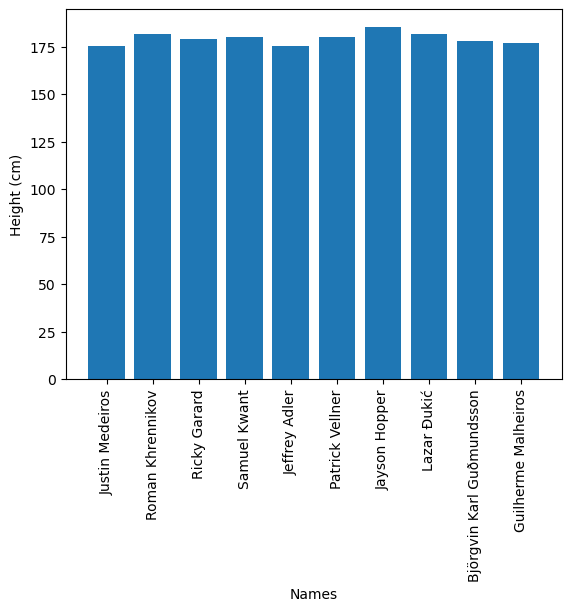

In [238]:
top10 = df_games_info_competitors[df_games_info_competitors['year'] == 2022].head(10)

# create a bar chart of the height data
plt.bar(top10['competitorName'], top10['heightInCm'],)

# add x-axis and y-axis labels
plt.xlabel('Names')
plt.ylabel('Height (cm)')

# rotate the x-axis labels
plt.xticks(rotation=90)

plt.show()

In [252]:
# Create separate dataframes for each gender
male_df = df_games_info_competitors[df_games_info_competitors['gender'] == 'M']
female_df = df_games_info_competitors[df_games_info_competitors['gender'] == 'F']

In [253]:
df_games_info_competitors['gender'].unique()

array(['M', 'F'], dtype=object)

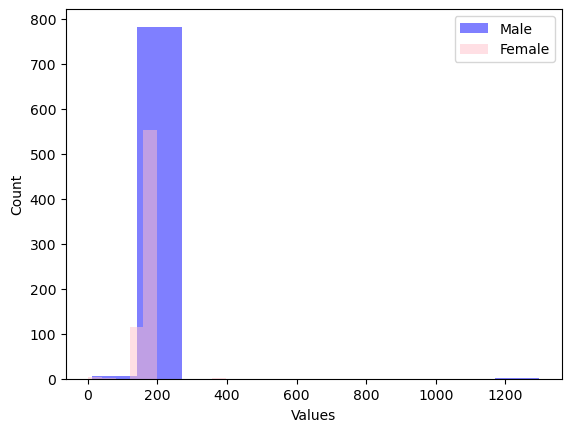

In [254]:
# Plot the histograms
plt.hist(male_df['heightInCm'], color='blue', alpha=0.5, label='Male')
plt.hist(female_df['heightInCm'], color='pink', alpha=0.5, label='Female')

# Add legend and labels
plt.legend()
plt.xlabel('Values')
plt.ylabel('Count')

# Show the plot
plt.show()

In [258]:
male_df[male_df['heightInCm'] == male_df['heightInCm'].max()]

competitorId competitorName firstName lastName status postCompStatus  \
285       109388   Angel Orozco     Angel   Orozco    CUT                  

    gender profilePicS3key countryOfOriginCode countryOfOriginName  ...  \
285      M  men-square.jpg                                          ...   

    divisionId affiliateId affiliateName age  height  weight  teamCaptain  \
285          1        None                28  511 in  205 lb            0   

    heightInCm weightInKg  year  
285     1297.9       93.0  2009  

[1 rows x 23 columns]

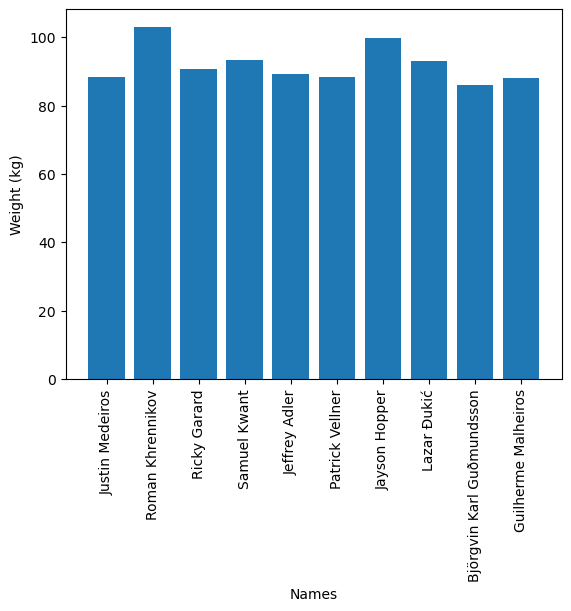

In [31]:
top10 = df_games_info_competitors.head(10)

# create a bar chart of the height data
plt.bar(top10['competitorName'], top10['weightInKg'],)

# add x-axis and y-axis labels
plt.xlabel('Names')
plt.ylabel('Weight (kg)')

# rotate the x-axis labels
plt.xticks(rotation=90)

plt.show()

In [291]:
def gamesInfoScores(year=2022, division=1):
    # create a dataframe to store the scores
    scoresDf = pd.DataFrame()
    # collecting data on the specified games session
    gamesInfoCall = gamesInfo(year=year,division=division)
    # determining what division value we need
    if division == 1:
        divisionValue = [1]
    elif division == 2:
        divisionValue = [2]
    # else we just take both divisions
    else:
        divisionValue = [1,2]
    
    for j in range(0,len(divisionValue)):
        # get the json data from the web service
        response = gamesJsonDump(year=year, division=divisionValue[j])
        for i in range(0, gamesInfoCall[2]):
            # results form running gamesInfo funcation
            scoresJson = response['leaderboardRows'][i]['scores']
            tempDf = pd.json_normalize(scoresJson)
            tempDf['competitorId'] = response['leaderboardRows'][i]['entrant']['competitorId']
            tempDf['division'] = divisionValue[j]
            # Concatenate the DataFrame with the existing DataFrame
            scoresDf = pd.concat([scoresDf, tempDf], ignore_index=True)
    # transformation of the data
    # some athletes got a DF score due to withdrawing from competiton before first event
    # if len(competitorData['overallScore']) < 1:
    #     df_cfgMales.loc[i,'overallScore'] = "0" 

    return(scoresDf)

SyntaxError: non-default argument follows default argument (581231218.py, line 1)

In [294]:
gamesInfoScores(2020,1)

ordinal rank score valid scoreDisplay       scoreIdentifier  \
0          1    1   100     1         3:08  fd69cb83976042a40b2f   
1          2    4    88     1       425 lb  c19135e3cd0bc7579764   
2          3    1   100     1         2:44  330d758bbd555ba25ecd   
3          4    8    72     1      2:55.20  388301719cfceaba4bc7   
4          5    1   100     1        17:50  48118b0d264137489e00   
..       ...  ...   ...   ...          ...                   ...   
595       16          0                     5e28fd0c71aeed055437   
596       17          0                     9b52a55b3e7c1f0a4985   
597       18          0                     e36ac94cf7efa29af66d   
598       19          0                     37a19dfa21ea4ff4c02c   
599       20          0                     f531a98d84556d64e734   

    mobileScoreDisplay scaled video heat lane breakdown competitorId  division  
0                           0     0             100 pts       153604         1  
1                           0     0              88 pts       153604         1  
2                           0     0             100 pts       153604         1  
3                           0     0              72 pts       153604         1  
4                           0     0             100 pts       153604         1  
..                 ...    ...   ...  ...  ...       ...          ...       ...  
595                         0     0                           234569         1  
596                         0     0                           234569         1  
597                         0     0                           234569         1  
598                         0     0                           234569         1  
599                         0     0                           234569         1  

[600 rows x 14 columns]

In [263]:
gamesInfo(2019,1)

[52, 3, 144, 12]

In [253]:
results = pd.merge(gamesInfoScoresFinal, competitorsInfo[['competitorId','competitorName']], on='competitorId')

In [255]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 560 entries, 0 to 559
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ordinal             560 non-null    int64 
 1   rank                560 non-null    object
 2   score               560 non-null    object
 3   valid               560 non-null    object
 4   scoreDisplay        560 non-null    object
 5   scoreIdentifier     560 non-null    object
 6   mobileScoreDisplay  560 non-null    object
 7   scaled              560 non-null    object
 8   video               560 non-null    object
 9   heat                560 non-null    object
 10  lane                560 non-null    object
 11  breakdown           521 non-null    object
 12  competitorId        560 non-null    object
 13  competitorName      560 non-null    object
dtypes: int64(1), object(13)
memory usage: 65.6+ KB


In [259]:
# convert to numeric and check for NaN values
non_numeric = df[pd.to_numeric(df['scoreDisplay'], errors='coerce').isnull()]
non_numeric

ordinal rank score valid scoreDisplay       scoreIdentifier  \
0         1    1   100     1     36:47.61  8cd42e7335a9f58c2c5c   
1         2    2    97     1     06:58.74  47406f45a1013a3d1af7   
2         3    3    94     1       16 rep  fc8ecef95523ddaa4fcb   
3         4    5    88     1         5 pt  2991f049897ee92f2fd9   
4         5    7    82     1     09:49.82  54c34a0f6157e81313d0   
..      ...  ...   ...   ...          ...                   ...   
9        10   33    16     1     04:49.82  c9faee5905ac44a713a8   
10       11   20    43     1       310 lb  4be1ee3a0ce29eaca7c3   
11       12   31     0                     2e71160ae2cfcffa9fcb   
12       13   30     0                     ade47f11f203f75e4d19   
13       14   30     0                     e1b39f0f11d788a9ce56   

   mobileScoreDisplay scaled video heat lane breakdown  
0                          0     0             100 pts  
1                          0     0              97 pts  
2                          0     0              94 pts  
3                          0     0              88 pts  
4                          0     0              82 pts  
..                ...    ...   ...  ...  ...       ...  
9                          0     0              16 pts  
10                         0     0              43 pts  
11                         0     0                 NaN  
12                         0     0                 NaN  
13                         0     0                 NaN  

[532 rows x 12 columns]